In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
import os

a. Image processing
==

During this step, the following occurs:
 1. Resizing to 64x64 for all images
 2. Saving the 64x64 files to a separate directory named "edited"


Observations and experimentation:
64x64 as first pass
first image as 4 as 3rd param. (RGBA: transparency. need to see how to drop it, convert to rgb isn't enough)
8th image no 3rd param.
does not contain apple_34.
use grayscale images instead of color?

In [144]:
from os.path import isfile
import glob

curr_dir = os.getcwd()
train_path = curr_dir + "/train/"
test_path = curr_dir + "/test/"

files_train = [img for img in glob.glob(train_path + "*.jpg")]
files_test = [img for img in glob.glob(train_path + "*.jpg")]

[]

In [145]:
x_resize = 64
y_resize = 64
# kernel_size
# image augmentation: imageDataGen & cutMix, Mix
# colab -> GPU

In [153]:
# TODO: write a function to create the directory automatically,
# if dir exists, do not create the dir..
def process_image(files, path):
    x = None
    y = []
    for i in range(len(files)):
        img = Image.open(files[i])
        img_resize = img.resize((x_resize, y_resize))
        if img_resize.mode in ["RGBA", "P"]:
            img_resize = img_resize.convert("RGB")
        if x is None:
            x = img_resize
        else:
            x = np.concatenate((x, img_resize))
        y.append(os.path.basename(files[i]).split('_')[0])

    x = x.reshape(-1, x_resize, y_resize, 3)
    le = LabelEncoder()
    y = le.fit_transform(y)

    name = os.path.basename(files[i]).split('.')[0]
    img_resize.save(path + "edited/" + name + "_{}x{}.jpg".format(x_resize, y_resize))

    return x,y

In [155]:
x_train, y_train = process_image(files_train, train_path)
x_test, y_test = process_image(files_test, test_path)

b. Creating train and test arrays
==
During this step, the following occurs:
 1. Reading 64x64 image data
 2. Creating labels for the data based on image name
 3. Concatenating the images and storing them in our train dataset
 4. Storing label data in our test array



In [ ]:
dict = {"apple": 96, "orange": 96, "banana": 96, "mixed": 20}
for path in ["train/","test/"]:
    for k,v in dict.items():
        for i in range(v):
            process_image(i, k, path)
            create_arr(i, k, path)

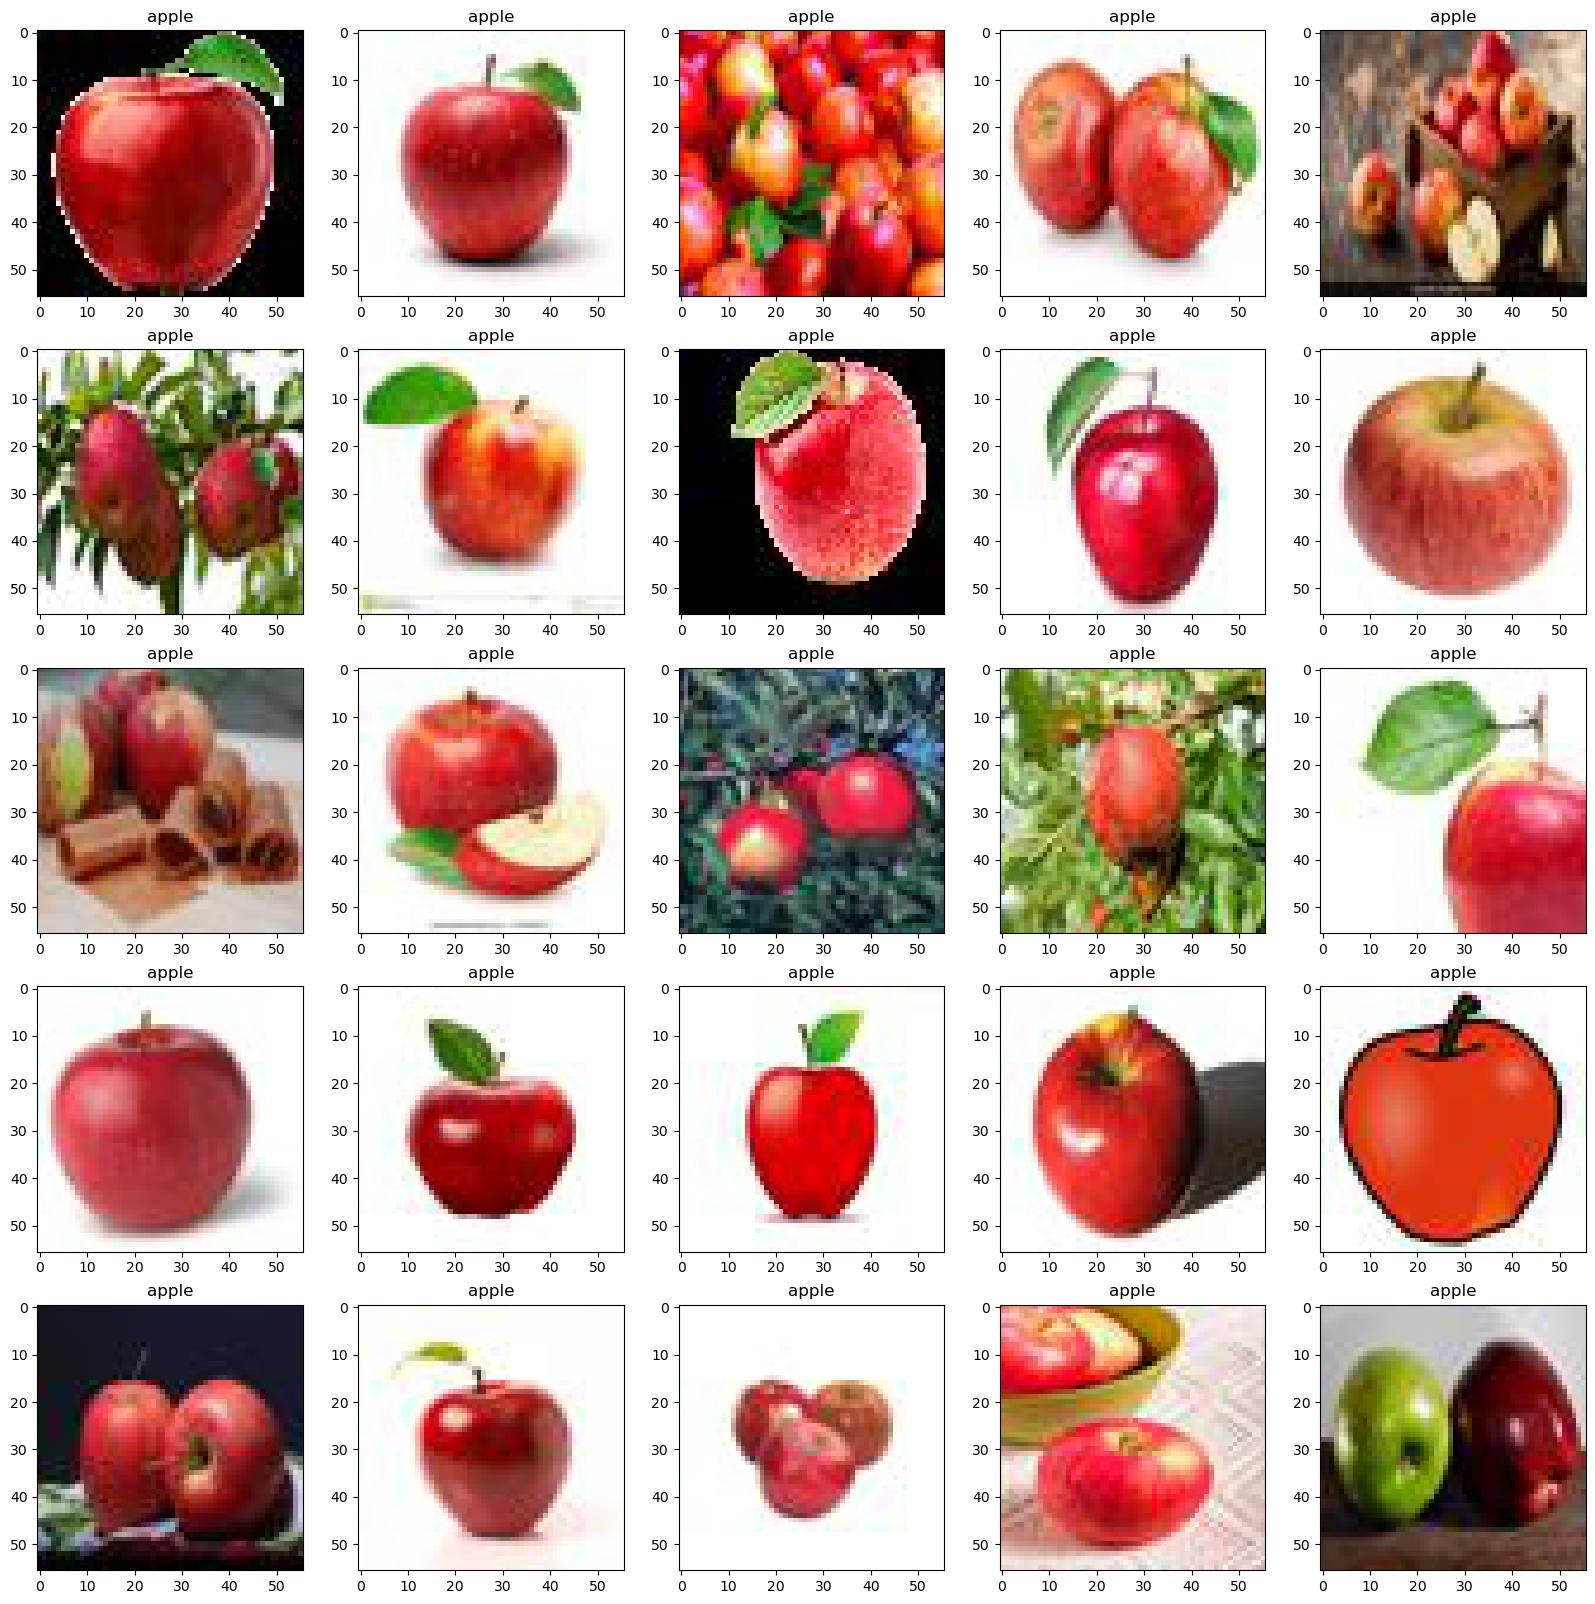

In [53]:
# preview for train images
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(train_img[i])
    plt.title(train_class[i])
plt.show()

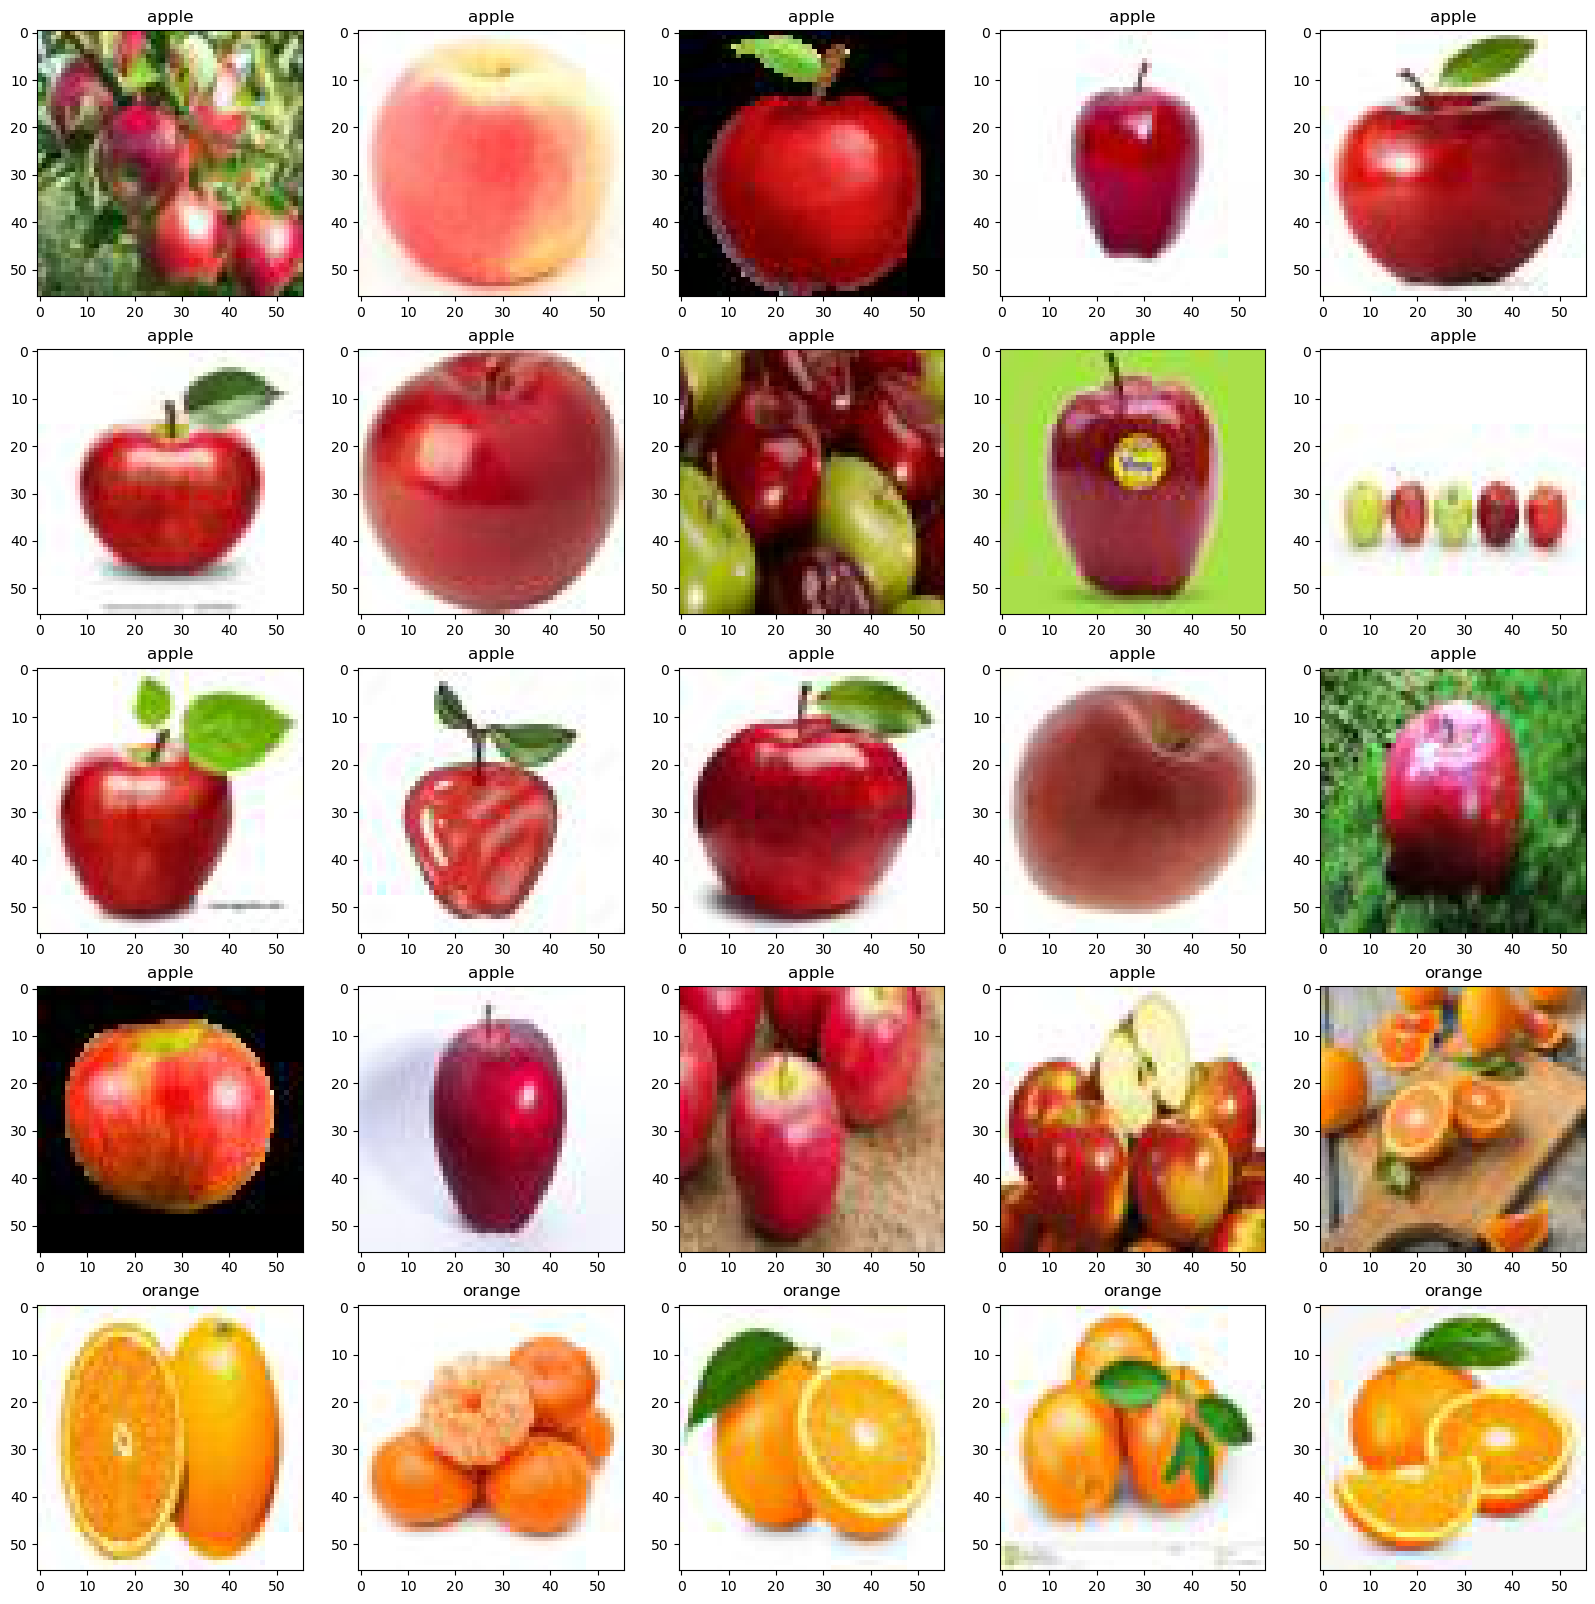

In [54]:
# preview of test images
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(test_img[i])
    plt.title(test_class[i])
plt.show()

In [15]:
train = np.array(train_img)
train_labels = np.array(train_class)
test = np.array(test_img)
test_labels = np.array(test_class)

In [55]:
print(train.shape)
print(train_labels.shape)
print(test.shape)
print(test_labels.shape)

(240, 64, 64, 3)
(240,)
(60, 64, 64, 3)
(60,)


In [17]:
from sklearn.preprocessing import LabelEncoder
# unable to use keras' encoder as it only works for ints.
# use sklearn instead
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
# try out with one hot encoding

In [18]:
# normalize
train = train/255
test = test/255

c. Build the model
==

In [19]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(img_size, img_size, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
hist = model.fit(train, train_labels, batch_size=10, epochs=50)


Epoch 1/50


/Users/xinyitay/miniforge3/envs/gdiptf/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


24/24 [==============================] - 1s 12ms/step - loss: 1.2077 - accuracy: 0.4417
Epoch 2/50
24/24 [==============================] - 0s 13ms/step - loss: 0.8463 - accuracy: 0.6792

d. Test our model
==

Observe the loss and accuracy over training

In [22]:
loss, accuracy = model.evaluate(test,test_labels)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 40ms/step - loss: 1.3562 - accuracy: 0.9000
1.3561500310897827
0.9000000357627869


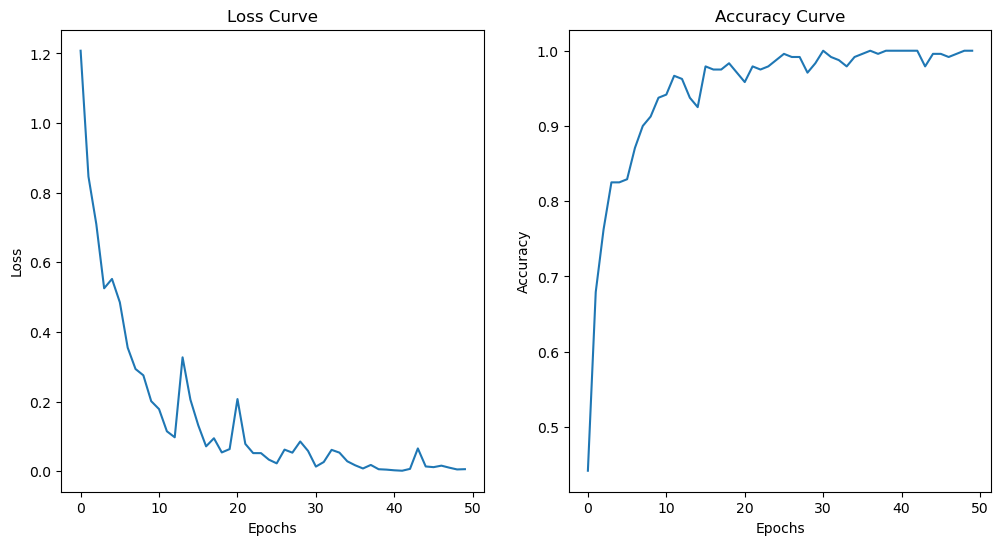

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt
ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

In [24]:
predictions = model.predict(test)


e. Plot images with labels to show accuracy of predictions
==
1. Define function to plot image
2. Define function to plot bar chart to show relative probabilities


In [25]:
def plot_image(i, pred, true_label, img_arr):
    plt.grid(False)
    plt.imshow(img_arr[i])

    pred_label = np.argmax(pred[i])

    if pred_label == true_label[i]:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("predicted: {} {:2.0f}% (actual: {})".format(class_names[pred_label],
                                                           100*np.max(pred[i]),
                                                           class_names[true_label[i]]),
                                                           color=color)

In [26]:
def plot_probs(i, pred, true_label):
    plt.xticks(range(4), class_names, rotation=45)
    # cannot take argmax, must take other indices also. EXCEPT the pred.
    # np.delete abit inefficient time wise
    pred_arr = np.arange(0,4,1)
    pred_arr = np.delete(pred_arr, true_label[i])
    plot = plt.bar(range(4),pred[i])
    plt.ylim([0,1])

    for label in pred_arr:
        plot[label].set_color('red')
    plot[true_label[i]].set_color('green')

3. Plot test images with labels and probabilities of prediction

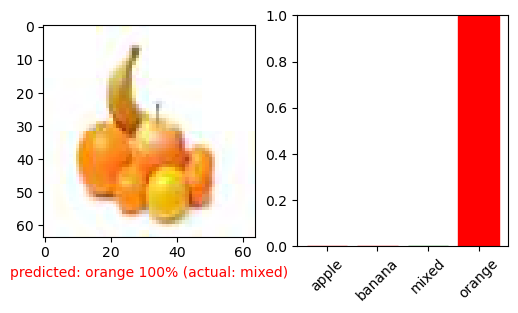

In [27]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions, test_labels, test)
plt.subplot(1,2,2)
plot_probs(0, predictions, test_labels)
plt.show()

In [28]:
num_rows = 10
num_cols = 6

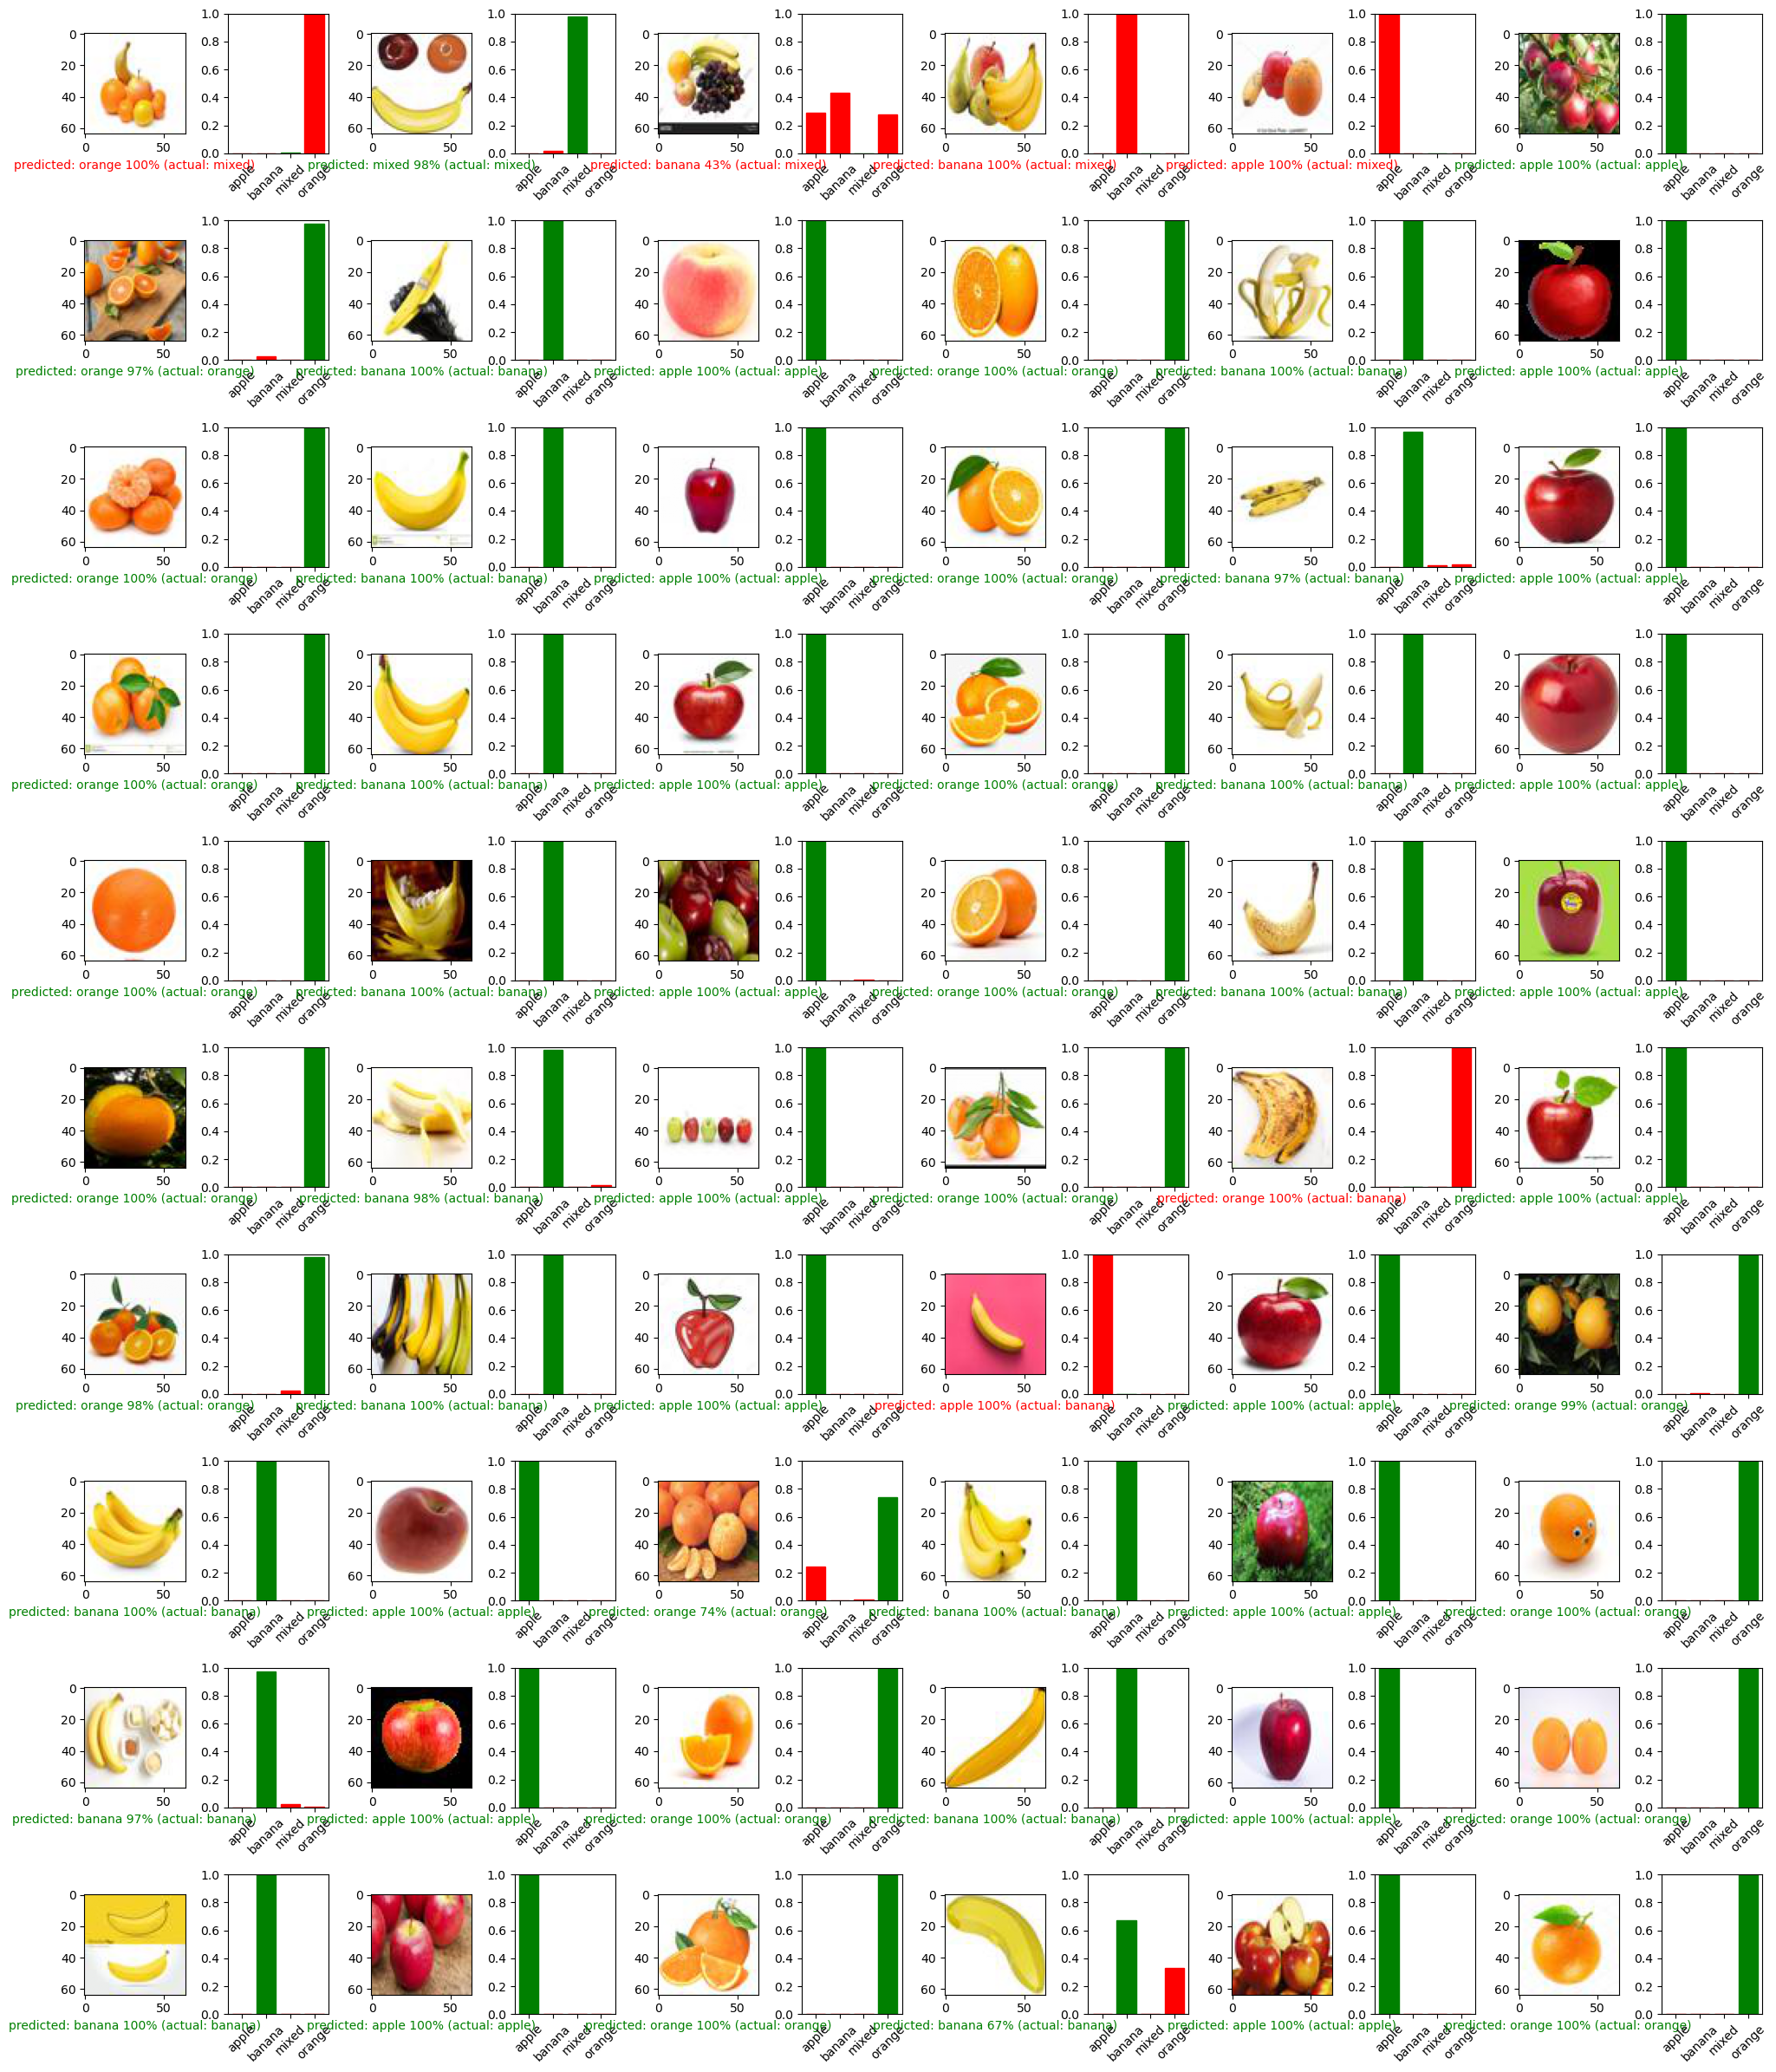

In [30]:
num_images = num_rows * num_cols
# 2x figure size
plt.figure(figsize=(2*num_rows, 2*2*num_cols))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_probs(i, predictions, test_labels)
plt.tight_layout()
plt.show()

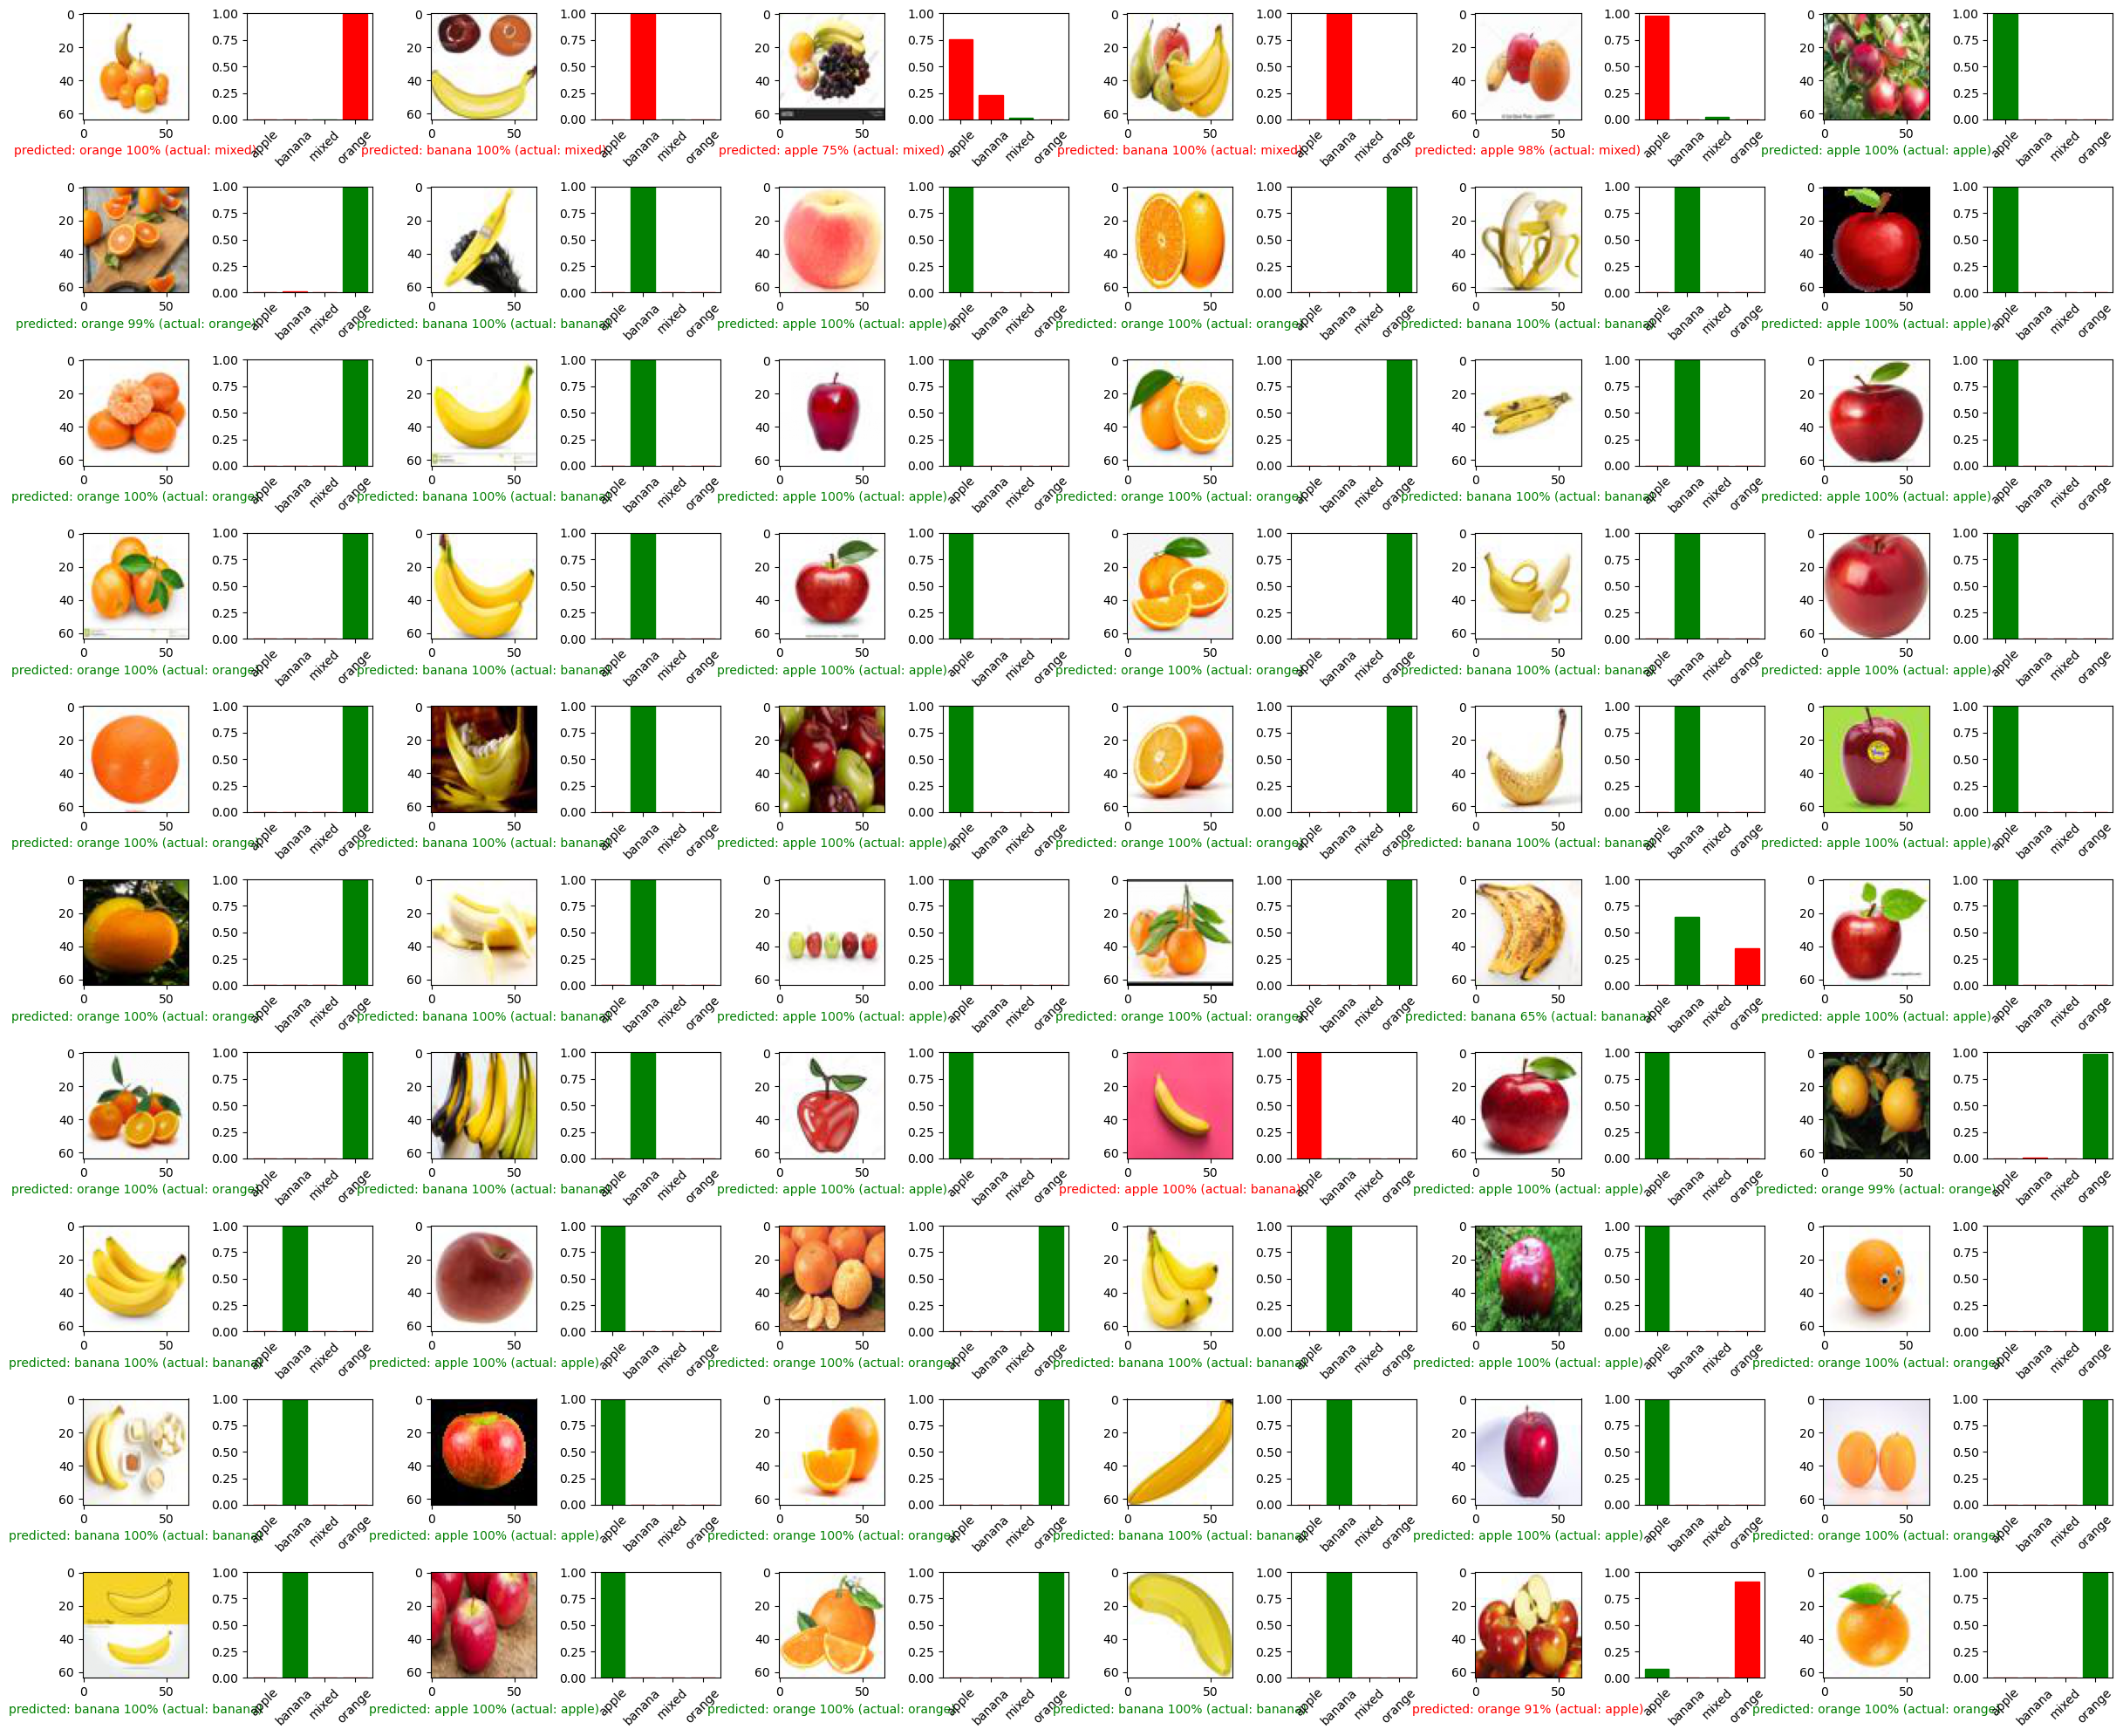

In [98]:
#looks like they learn from color
# image augmentation: mb change rgb hues?

In [99]:
#explore early stopping, pipeline

In [ ]:
# data augmentation